# Lazy-loading Data

By default the `datacube` library does not use Dask when loading data, meaning that when `dc.load()` is used the data being queried will loaded into memory. Lazy-loading data refers to data only being loaded into memory when necessary for analysis. In order to lazy-load data, we pass the `dask_chunks` parameter into the `dc.load()` statement. 

In this section we will lazy-load data by passing the `dask_chunks` parameter into the `.load()` function, and explore the data structure of lazy-loaded data. 

## Load Packages

In [1]:
import datacube 
import matplotlib.pyplot as plt
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Connecting to the datacube 

In [2]:
dc = datacube.Datacube(app='Step1')

## Standard load function
The `dc.load()` command specifies the product, measurements (bands), x, y coordinates and the time range.

In [3]:
data = dc.load(product='gm_s2_annual',
              measurements=['red','green', 'blue', 'nir'],
              x=(31.90, 32.00),
              y=(30.49, 30.40),
              time=('2020-01-01', '2020-12-31'))

data

<xarray.Dataset>
Dimensions:      (time: 1, y: 994, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 3.713e+06 3.713e+06 ... 3.703e+06 3.703e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.088e+06 3.088e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 2863 2892 3069 3104 ... 3367 3386 3425 3414
    green        (time, y, x) uint16 2222 2274 2403 2390 ... 2544 2555 2591 2589
    blue         (time, y, x) uint16 1514 1554 1644 1618 ... 1708 1706 1726 1732
    nir          (time, y, x) uint16 3832 3873 4010 3999 ... 3862 3893 3952 3937
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Lazy-loading the same data
Passing `dask_chunks` into the load query initialises lazy loading the data, whereby `dask.array` objects are returned instead of individual values until called upon. 

In [4]:
# lazy loading data through dask chunks parameter
lazy_data = dc.load(product='gm_s2_annual',
                   measurements=['red','green', 'blue', 'nir'],
                   x=(31.90, 32.00),
                   y=(30.49, 30.40),
                   time=('2020-01-01', '2020-12-31'),
                   dask_chunks={'time':1,'x':500, 'y':500})
# return data
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 994, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 3.713e+06 3.713e+06 ... 3.703e+06 3.703e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.088e+06 3.088e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Plotting RGB image of the study area

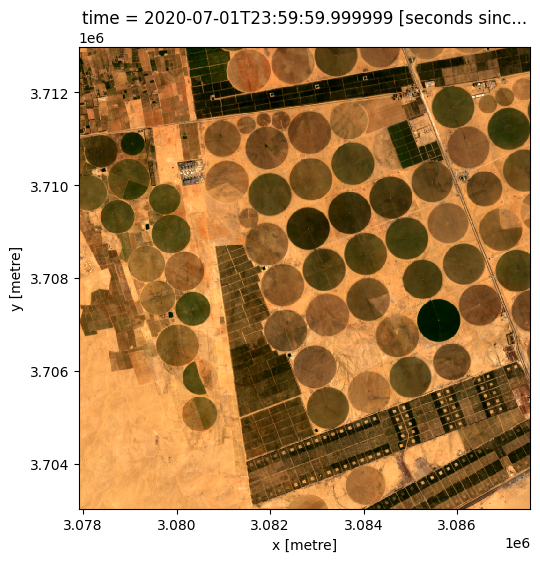

In [5]:
# View a rgb (true colour) image of study area
rgb(lazy_data, bands=['red', 'green', 'blue'])

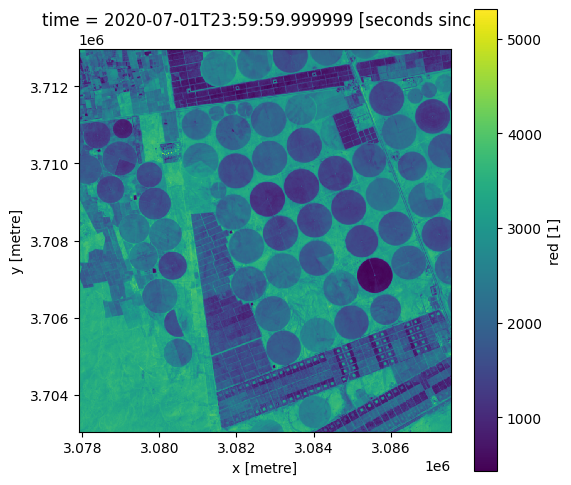

In [6]:
# formatting the figure 
fig , axis = plt.subplots(1, 1, figsize=(6, 6))
axis.set_aspect('equal')

lazy_data.red.plot(ax= axis)

In this section you have ‘lazy-loaded’ data by passing the `dask_chunks` parameter into the load statement.

### Key Concepts
* Until now, the `.load()` function has been used to load data straight into memory
* Dask is a tool used to break data into manageable chunks, ideal for data management
* Adding the `dask_chunks` parameter to the standard `.load()` function calls for data to be **lazy-loaded**
    * Lazy-loading results in data only being loaded when necessary to complete a computation, until specific data is required the xarray.dataset is comprised of dask.array objects which act as placeholders, not specific values
* To break a dataset into chunks using Dask, we pass `dask_chunks` into the load query and specify `‘time’`, `‘x’`, and `‘y’` parameters (e.g., `dask_chunks = {'time': 1, 'x': 500, 'y': 500}`)

#### Further information
**Dask** is a tool used for data management, this process breaks data down into manageable chunks stored in memory. In short, Dask enables you to
* analyse larger-than-memory datasets
* efficiently run computations

Dask compatible operations are not executed until computation or visualisation of the final results are called upon.

##### Standard Load

In this section we used the standard `dc.load()` function to load data straight into memory. Until now, we have used this method of loading data from the Datacube into Jupyter notebooks. However, loading data across large areas or over prolonged timespans can cause Jupyter notebooks to crash. To load larger datasets, we can use Dask functionalities to manage computation within a limited memory limit.

##### Lazy-loading data

Lazy-loading data refers to loading data only when it is required to complete a calculation. 
To lazy-load data we add the `dask_chunks = {‘time’:, ‘x’:, ‘y’:}` parameter into the `dc.load()` statement. When we lazy-load a dataset, the returned `xarray.dataset` is comprised of `dask.array` objects. 

Lazy-loading data saves both time and memory which would otherwise be spent storing the data within your computer’s local memory.

> **Note**: The `.load()` command with `dask_chunks` parameter returns much faster as it is not loading any data into memory. The comparison below shows returned data using the standard load function, and then returned `dask.array` objects when lazy-loading the same `data.datacube`. 

<img align="middle" src="../../_static/sandbox/dask-howto/object-comparison.png" alt="Comparison between loaded and lazy-loaded objects." width="1000"> 

##### Factoring Dask array shape for chunking

When chunking data, we need to factor in the shape of the data, type of computation, and the memory available. Below is an example showing an excess number of chunks containing small amounts of data (480 chunks with each chunk storing 500 kilobytes of data). Applying the same chunking parameters from earlier in this exercise (x: 500, y: 500) is inefficient for the dataset. Rechunking the data and factoring chunk size which can reduce the number of times data must be read from file (fewer tasks and chunks) is more time effective.

<img align="middle" src="../../_static/sandbox/dask-howto/chunk-size-comparison.png" alt="Comparison between different chunk sizes." width="700">

#### Advanced explanation

**Larger-than-memory** refers to datasets which require more storage beyond available memory, for example:

> **Example:** To load three bands (red, green, blue), each bands datatype will be stored as an unsigned integer (uint16). This means that each pixel you wish to load is 16 bits which is equivalent to 2 bytes. To load an area which is 100 pixels by 100 pixels, you will need to load 10,000 pixels per band, which for three bands this will require 30,000 pixels to be loaded. At 2 bytes per pixel, this totals 60,000 bytes (60 Kilobytes or 0.06 Gigabytes). This example requires a small amount of memory which easily fits into the memory available in your Sandbox. 
<br> <br> However, if you wanted to load 12 bands over a larger area that spanned 100,000 pixels by 100,000 pixels (10,000km by 10,000km for 10m Sentinel-2 resolution), that would require 240 Gigabytes (100,000 pixels x 100,000 pixels x 12 bands x 2 bytes = 240 Gigabytes). As the default Sandbox environment offers 16G Memory, this hypothetical dataset would require additional storage beyond what is available and therefore considered to be larger-than-memory.
